In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import numpy as np
import skimage.io
import sklearn.cluster
import skimage.transform
import skimage.segmentation
import pandas
import json
import scipy.spatial
import networkx 
    

In [5]:
%%file paintings.json
[
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Sandro_Botticelli_-_La_nascita_di_Venere_-_Google_Art_Project_-_edited.jpg/1280px-Sandro_Botticelli_-_La_nascita_di_Venere_-_Google_Art_Project_-_edited.jpg", 
    "info": "https://en.wikipedia.org/wiki/The_Birth_of_Venus", 
    "painter": "Sandro Botticelli", 
    "title": "the Birth of Venus"
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Le_bassin_aux_nymph%C3%A9as_-_Claude_Monet.jpg/1280px-Le_bassin_aux_nymph%C3%A9as_-_Claude_Monet.jpg", 
    "info": "https://en.wikipedia.org/wiki/Le_Bassin_Aux_Nymph%C3%A9as", 
    "painter": "Claude Monet", 
    "title": "Le Bassin Aux Nympheas"
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/2/28/The_Nightwatch_by_Rembrandt.jpg", 
    "painter": "Rembrandt van Rijn", 
    "title": "de Nachtwacht"
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/The_Scream.jpg/804px-The_Scream.jpg", 
    "painter": "Edvard Munch", 
    "title": "Skrik"
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Meisje_met_de_parel.jpg/875px-Meisje_met_de_parel.jpg", 
    "painter": "Johannes Vermeer", 
    "title": "Meisje met de parel"
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg", 
    "painter": "Pablo Picasso", 
    "title": "Guernica "
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/Creaci%C3%B3n_de_Ad%C3%A1m.jpg/1280px-Creaci%C3%B3n_de_Ad%C3%A1m.jpg", 
    "painter": "Michelangelo di Lodovico Buonarroti Simoni", 
    "title": "Creazione di Adamo"
  }, 
  {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/%C3%9Altima_Cena_-_Da_Vinci_5.jpg/1280px-%C3%9Altima_Cena_-_Da_Vinci_5.jpg", 
    "painter": "Leonardo da Vinci", 
    "title": "Il cenacolo"
  }
]

Overwriting paintings.json


In [6]:
# Let's start with the paintings
# http://www.touropia.com/most-famous-paintings/
paintings = json.load(open('paintings.json'))

/Users/fedor/.virtualenvs/py3/lib/python3.5/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (163328704 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


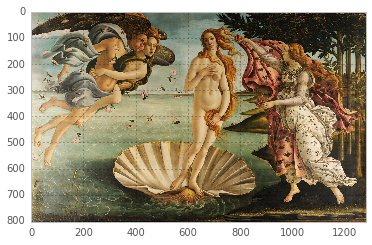

In [21]:
for painting in paintings:
    painting['array'] = skimage.io.imread(painting['url'])
plt.imshow(paintings[0]['array'])

In [40]:
for painting in paintings:
    painting['n_pixels'] = np.prod(painting['array'].shape[:2])
    if painting['n_pixels'] > 2e6:
        scale = 1.0/np.sqrt(painting['n_pixels'] // 1e6)
        painting['array'] = skimage.transform.rescale(painting['array'], scale)
        print(painting['array'].shape)


/Users/fedor/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


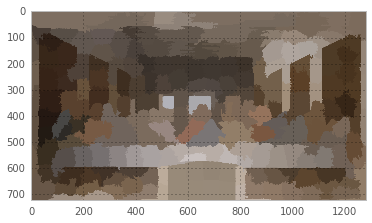

In [41]:
for painting in paintings:
    image = painting['array']
    label = skimage.segmentation.slic(image, n_segments=256, convert2lab=True)
    segmented = skimage.color.label2rgb(label, image, kind='avg')
    plt.imshow(segmented)
    colors = []
    for label_ in range(label.max() + 1):
        color = image[label_ == label][0]
        colors.append(color)
    colors = np.array(colors)
    hsvs = skimage.color.rgb2hsv(colors[:,np.newaxis,:]).squeeze()
    labs = skimage.color.rgb2lab(colors[:,np.newaxis,:]).squeeze()

    clusters = sklearn.cluster.KMeans(n_clusters=15)
    clusters.fit(labs)
    lab_centers = clusters.cluster_centers_
    rgb_centers = skimage.color.luv2rgb(lab_centers[:,np.newaxis,:]).squeeze()
    hsv_centers = skimage.color.rgb2hsv(rgb_centers[:,np.newaxis,:]).squeeze()
    df = pandas.DataFrame(data=dict(h=hsv_centers[:,0], s=hsv_centers[:,1], v=hsv_centers[:,2]))
    sorted_hsv = np.array(df.sort(columns=['v', 'h', 's']))[:,np.newaxis,:]
    sorted_rgb = skimage.color.hsv2rgb(sorted_hsv)
    painting['palette'] = sorted_rgb

In [42]:
def painting2palette(painting, ax=None):
    lab = skimage.color.rgb2lab(painting['array'])
    rgb = skimage.img_as_float(painting['array'])
    rgba = np.dstack([rgb, 0.7*np.ones((rgb.shape[0], rgb.shape[1]), dtype='float32')[:,:,np.newaxis]])
    n = 10000
    sample = np.arange(rgb.shape[0] * rgb.shape[1])
    np.random.shuffle(sample)
    sample = sample[:n]
    colors = rgba.reshape(rgba.shape[0] * rgba.shape[1], rgba.shape[2])[sample, :]

    points = lab.reshape(lab.shape[0] * lab.shape[1], lab.shape[2])[sample, :]
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(points[:,1], points[:,2], c=colors, linewidth=0, edgecolor='none')
    

(0.0, 2.0, 0.0, 8.0)

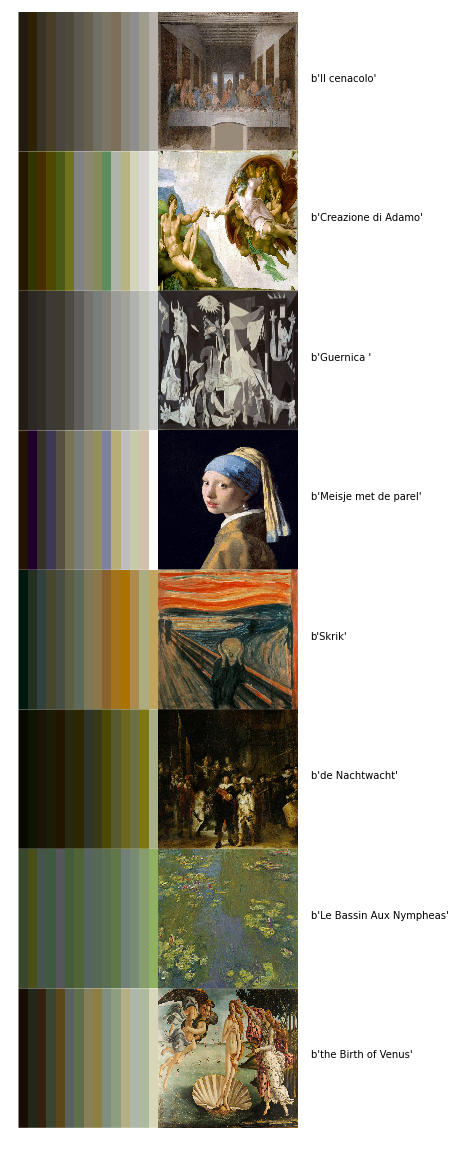

In [43]:
fig, ax = plt.subplots(figsize=(8,20))
for i, painting in enumerate(paintings):
    palette = painting['palette']
    ax.imshow(np.swapaxes(palette, 0, 1), extent=(0, 1, i, i+1), interpolation='none')
    ax.imshow(painting['array'], extent=(1,2,i, i+1))
    ax.text(2.1, i+0.5, painting['title'].encode('ascii'))
ax.autoscale()
ax.axis('off')


In [9]:
pandas

<module 'pandas' from '/Users/fedor/.virtualenvs/main/lib/python2.7/site-packages/pandas/__init__.pyc'>

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


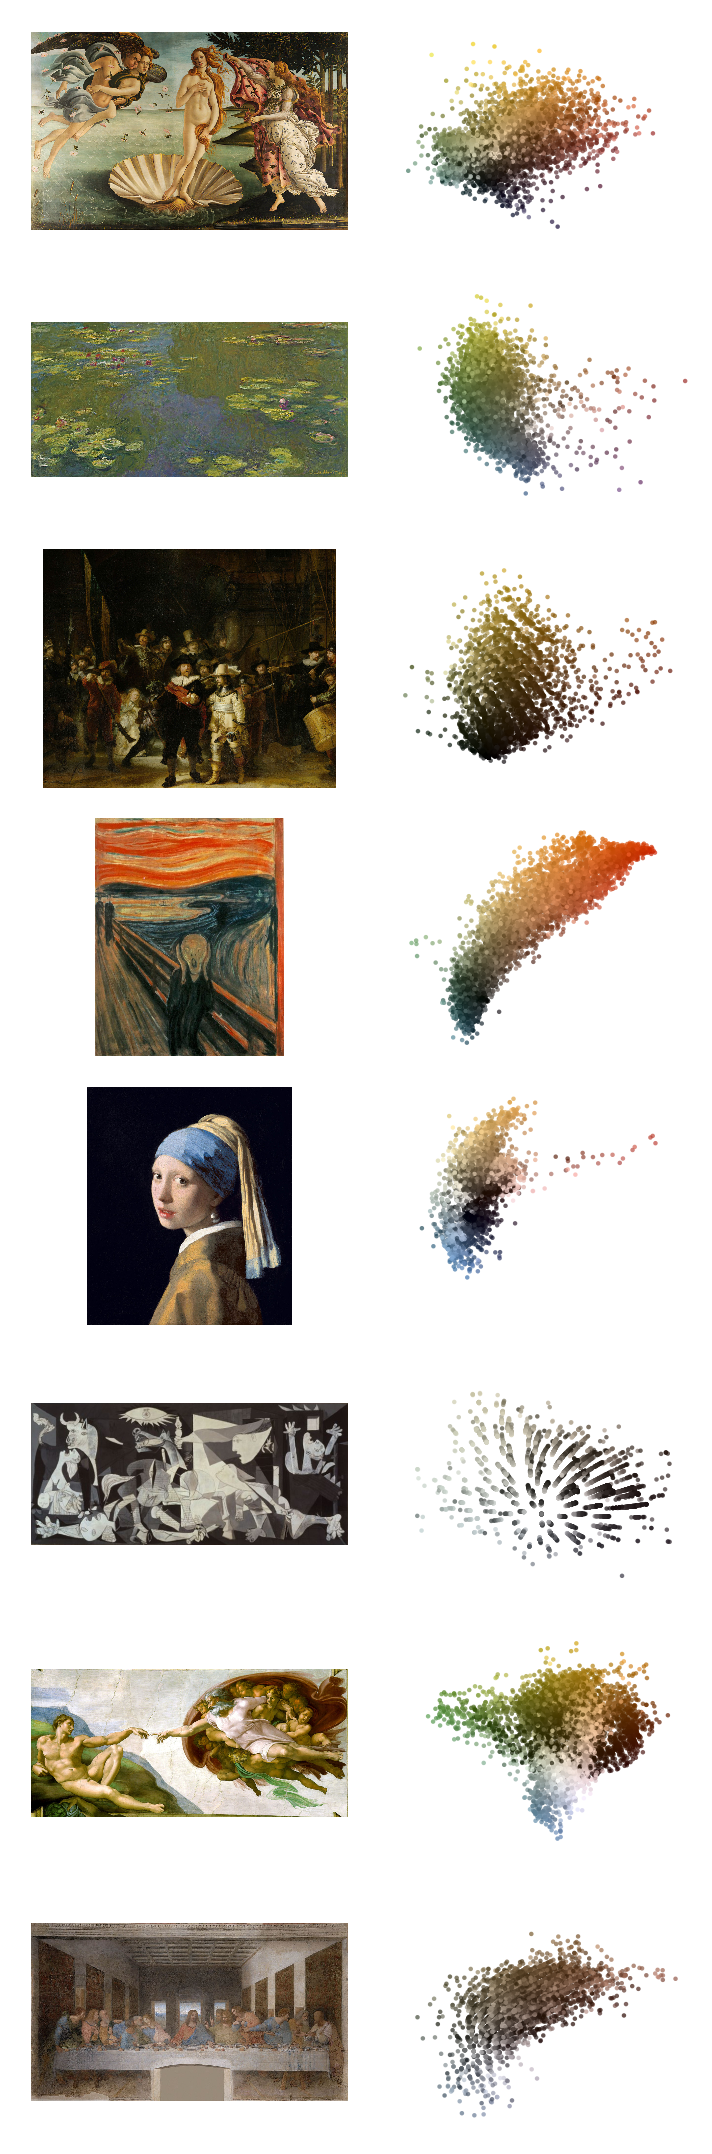

In [44]:
fig, axes = plt.subplots(len(paintings), 2, figsize=(10,30))
for i, (painting, axes_) in enumerate(zip(paintings, axes)):
    palette = painting['palette']
    axes_[0].imshow(painting['array'])
    axes_[0].axis('off')
    painting2palette(painting, ax=axes_[1])
    axes_[1].axis('off')
fig.tight_layout()
fig.savefig('paletteslab.png')

In [47]:
def painting2convex(painting, n_clusters=100):
    lab = skimage.color.rgb2lab(painting['array'])
    rgb = skimage.img_as_float(painting['array'])
    rgba = np.dstack([rgb, 0.7*np.ones((rgb.shape[0], rgb.shape[1]), dtype='float32')[:,:,np.newaxis]])
    n = 10000
    sample = np.random.choice(np.arange(rgb.shape[0] * rgb.shape[1]), n)
    
    colors = rgba.reshape(rgba.shape[0] * rgba.shape[1], rgba.shape[2])[sample, :]
    points = lab.reshape(lab.shape[0] * lab.shape[1], lab.shape[2])[sample, :]
    
    # add the convex hull for extreme colors
    hull = scipy.spatial.ConvexHull(points[:,1:])
    l = points[hull.vertices, 0]
    a = points[hull.vertices, 1]
    b = points[hull.vertices, 2]
    lab = np.dstack([l, a, b])
    if n_clusters:
        # create clusters of common colors 
        clusters = sklearn.cluster.KMeans(n_clusters=n_clusters)
        # in a,b space
        clusters.fit(points)
        # use the centers
        cluster_centers = clusters.cluster_centers_[np.newaxis,:,:]
        # append
        lab = np.concatenate([lab, cluster_centers], 1)
    # convert to rgb
    palette = skimage.color.lab2rgb(lab)
    # sort by hue
    palette_hsv = skimage.color.rgb2hsv(palette)
    idx = np.argsort(palette_hsv[0,:,0])
    return palette[:,idx,:]

In [48]:
painting = paintings[3]
palette = painting2convex(painting, n_clusters=0)

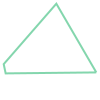

In [76]:
import shapely.geometry
contour = shapely.geometry.Polygon(palette[0])
a = contour.simplify(0.5)
a.exterior


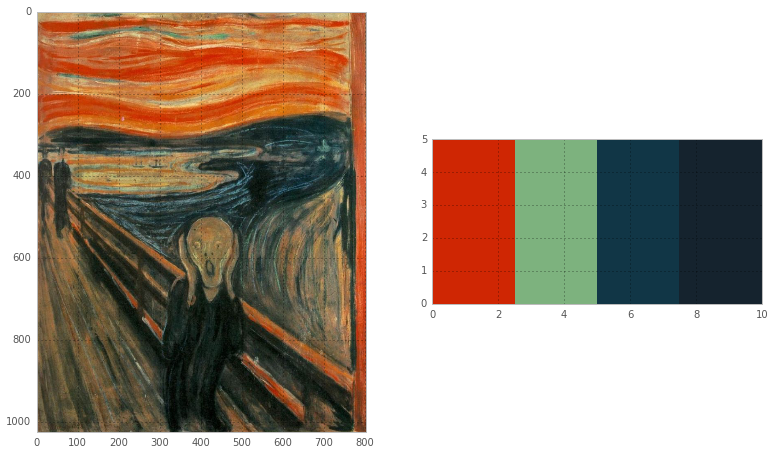

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(13,8))
axes[0].imshow(painting['array'])
axes[1].imshow(np.asarray(contour.simplify(0.5).exterior)[np.newaxis, :-1,:], interpolation='none', extent=(0,10, 0,5))

In [14]:
def palette2board(palette):
    """rgb palette with 1,n_colors, rgb dimension"""
    # generate a graph
    G = networkx.Graph()
    # add the nodes, labeld by idx
    G.add_nodes_from(range(palette.shape[1]))
    # convert to lab space for distance
    palette_lab = skimage.color.rgb2lab(palette)
    # compute the distance matrix
    A = np.tile(palette_lab[0], [palette_lab.shape[1], 1, 1])
    B = np.swapaxes(A, 0, 1)
    # use perceptual distance
    distance = skimage.color.deltaE_ciede2000(A, B)
    
    # add weights based on distance
    G.add_weighted_edges_from((from_, to, weight) for (from_, to), weight in np.ndenumerate(distance) if from_ > to)
    # create a data frame
    rows = []
    # use inital positions based on lab space
    pos = {i: (palette_lab[0,i,1], palette_lab[0,i,2]) for i in G.nodes() }
    # pull points apart using a spring layout (use k=1.5 otherwise you get outliers)
    for (i, (x,y)) in networkx.layout.spring_layout(G, k=1.5, pos=pos).items():
        row = dict(i=i, x=x, y=y, rgb=palette[0,i])
        rows.append(row)
    # return as a dataframe
    df = pandas.DataFrame(rows)
    return df

In [15]:
board = palette2board(palette)
#board.to_json(orient='records')

/Users/fedor/.virtualenvs/main/lib/python2.7/site-packages/networkx/drawing/layout.py:269: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pos==None:


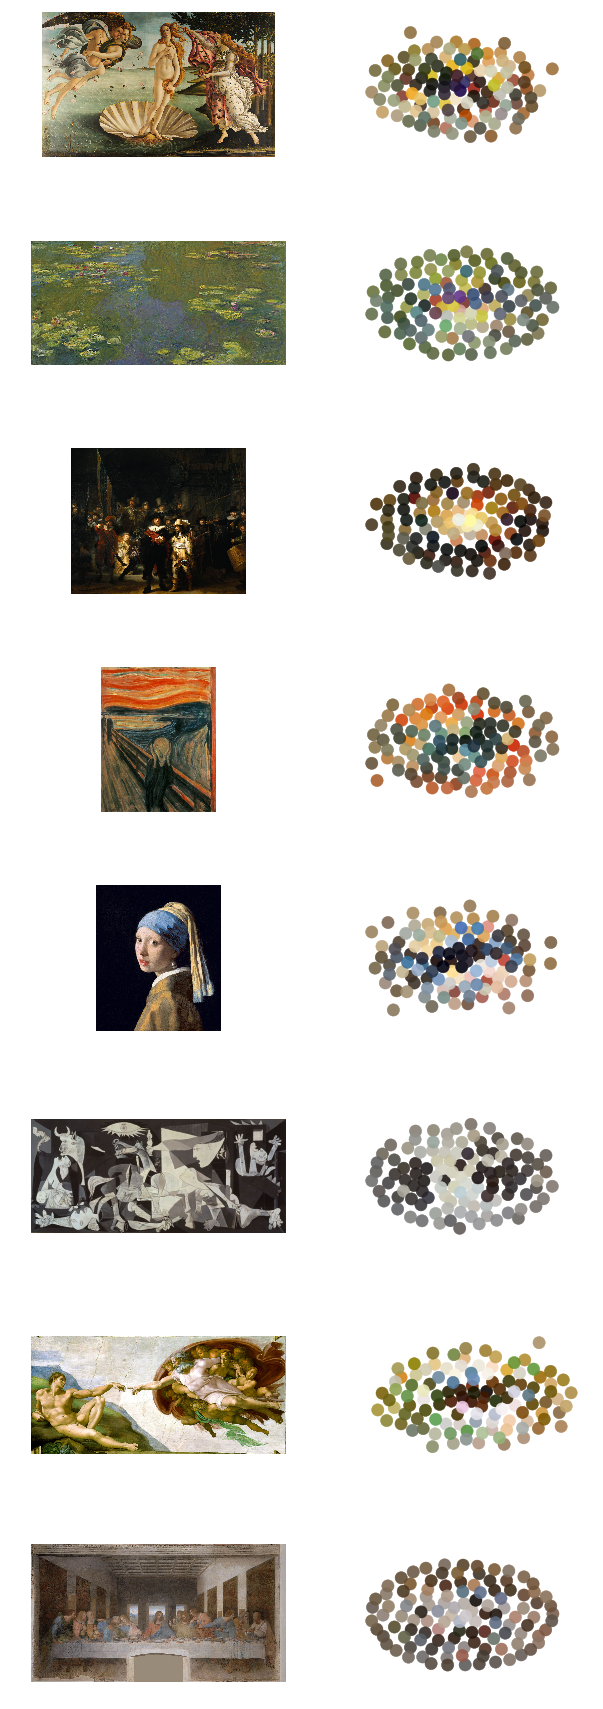

In [16]:
fig, axes = plt.subplots(len(paintings), 2, figsize=(10,30))
for i, (painting, axes_) in enumerate(zip(paintings, axes)):
    palette = painting['palette']
    axes_[0].imshow(painting['array'])
    axes_[0].axis('off')
    palette = painting2convex(painting)
    board = palette2board(palette)
    axes_[1].scatter(x=board['x'], y=board['y'], color=board['rgb'], s=150, alpha=0.9)
    axes_[1].axis('off')



In [17]:
output = []
keys = ["url", "info", "title", "painter"]
for painting in paintings:
    record = {key: painting.get(key, "") for key in keys}
    palette = painting2convex(painting)
    board = palette2board(palette)
    # convert to json compatible
    record['palette'] = json.loads(board.to_json(orient="records"))
    output.append(record)
with open('palettes.json', 'w') as f:
    json.dump(output, f, indent=2)